In [1]:
from IPython import display

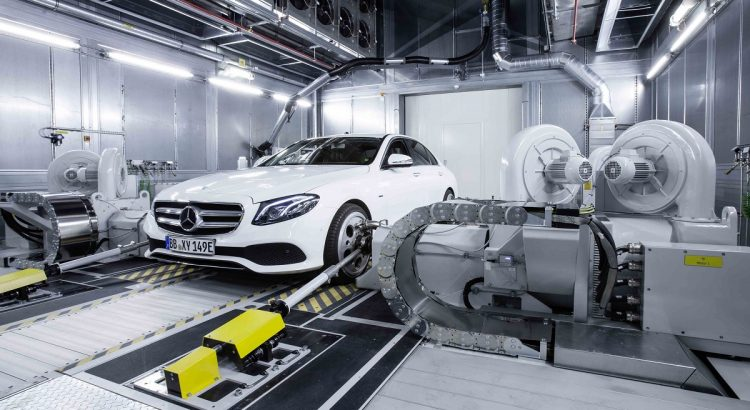

In [2]:
display.Image(".\daimler-mercedes_image_2.jpg")

Abstract

Mercedes Benz is Manufacturer of premium cars. Daimler’s Mercedes-Benz is the European leader among the premium car makers. This has been possible with quality Research, Engineering , Manufacturing and Testing. They also provide a variety of features for customers to customize their Mercedes-Benz. Now all these cars have to be tested for functionality of equipment within the car. They also have to meet quality standards and safety to achieve best performance when they hit the road. This requires the testing line within the factory to be versatile to handle every unique car. To tackle testing of a variety of cars, Company Engineers have built a robust testing system which can handle every unique configuration of the car. Testing line has to function efficiently as more the time the car spends on the testing, the more it contributes towards carbon emissions. Optimizing speed of testing keeps the production line eco-friendly. It is quite a challenge for company to optimize the speed of its testing system for so many possible feature combinations. It is complex and time-consuming without a smart numerical method. Being world’s biggest manufacturers of cars, it is crucial to have a production line which is efficient and has control over their greenhouse gas emissions.

<u><b>Machine Learning formulation of the business problem</b></u>

Company provides information of testing time of multiple cars with their particular configuration. With this data, we have to train a Machine Learning model which has to predict the Real valued output of car testing time for given labelled features which represents a set of car configurations. Model’s performance has to be measured using coefficient of determination (R^2 value). Model should be interpretable, so that which feature impacts the testing time can be extracted.

Machine learning model should have high metric score for predicted testing time. When model performance increases, predicted time is more accurate which drives testing of cars to be more organized and the speed of testing is improved. Thus reducing the carbon emissions during testing of cars. 

For Earlier analysis refer the following:
- Case_Study_1_FE_ML_Sachin_BU_1_olr
- Case_Study_1_FE_ML_Sachin_BU_2_olr
- Case_Study_1_FE_ML_Sachin_BU_3_olr
- Case_Study_1_FE_ML_Sachin_BU_4_FullData

### Post Training  analysis

In this section we will check how the model predictions vary compared to ground truth of the best model. 

This will help us understand why the model score is in the region of 0.5 to 0.56.

We have target variable which is continuous, so we will select a error threshold value to seperate the dataset into to good and bad predictions.

In [3]:
import joblib
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sb

Below function prepares the dataset for model training.

In [4]:
def featurize(X,encoder_list,best_features,two_feat_selc,three_feat_selc,pca,tSVD,F_ica,Dim_redn_corr_feat):
    ''' This function transforms categorical data to 
    target encoded features, adds best feature, two & three way interaction features and dimensionality reduction feature'''
    
    X0_encdr = encoder_list[0]
    X1_encdr = encoder_list[1] 
    X2_encdr = encoder_list[2] 
    X3_encdr = encoder_list[3]
    X5_encdr = encoder_list[4]
    X6_encdr = encoder_list[5]
    X8_encdr = encoder_list[6]
    
    X0_tgenc = X0_encdr.transform(X['X0'])
    X1_tgenc = X1_encdr.transform(X['X1'])
    X2_tgenc = X2_encdr.transform(X['X2'])
    X3_tgenc = X3_encdr.transform(X['X3'])
    X5_tgenc = X5_encdr.transform(X['X5'])
    X6_tgenc = X6_encdr.transform(X['X6'])
    X8_tgenc = X8_encdr.transform(X['X8'])
    
    X_1 = pd.concat([X0_tgenc,
                     X1_tgenc,
                     X2_tgenc,
                     X3_tgenc,
                     X5_tgenc,
                     X6_tgenc,
                     X8_tgenc,
                     X[best_features]],axis=1)
    
    # Generating dataframe for selected 2 feature combinations 
    two_feat_dict = dict()
    for feat in two_feat_selc:
        ft_list = feat.split('_')
        two_feat_dict[feat] = X[ft_list[0]] + X[ft_list[1]]
    two_feat_df = pd.DataFrame(two_feat_dict)
    
    # Generating dataframe for selected 3 feature combinations 
    three_feat_dict = dict()
    for feat in three_feat_selc:
        ft_list = feat.split('_')
        three_feat_dict[feat] = X[ft_list[0]] + X[ft_list[1]] + X[ft_list[2]]
    three_feat_df = pd.DataFrame(three_feat_dict)
    
    X_2 = pd.concat([X_1,
                     two_feat_df,
                     three_feat_df],axis=1)
    
    # Transforming target encoded features and best feature to Dimensional Reduction features
    X_pca = pca.transform(X_1)
    X_pca_df = pd.DataFrame(X_pca, index=list(X_1.index))
    X_pca_df.columns = [('pca_'+str(i)) for i in range(20)]
    
    X_tSVD = tSVD.transform(X_1)
    X_tSVD_df = pd.DataFrame(X_tSVD, index=list(X_1.index))
    X_tSVD_df.columns = [('tSVD_'+str(i)) for i in range(20)]
    
    X_Fica = F_ica.transform(X_1)
    X_Fica_df = pd.DataFrame(X_Fica, index=list(X_1.index))
    X_Fica_df.columns = [('ica_'+str(i)) for i in range(20)]
    
    X_3 = pd.concat([X_pca_df,
                     X_tSVD_df,
                     X_Fica_df,],axis=1)
    
    X_3 = X_3.drop(Dim_redn_corr_feat,axis=1)
    
    X_mod = pd.concat([X_2,
                       X_3,],axis=1)
    return X_mod

Below function returns the predictions of trained best model, the model itself, feature importance and modified data

In [5]:
def final_fun_1(X):
    '''
    This function predicts testing time of car for given configuration.
    Prediction is done after following transformation of data :
       - Removes the non important columns
       - Target encoders convert the categorical features to numerical values
       - pca, tSVD and F_ica does dimensionality reduction on the modified data.
       - adds two and three feature interactions
    '''
    start = time.time()
    # Verify columns size
    # Data columns with prediction values y
    cols1 = ['ID', 'y', 'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X61', 'X62', 'X63', 'X64', 'X65', 'X66', 'X67', 'X68', 'X69', 'X70', 'X71', 'X73', 'X74', 'X75', 'X76', 'X77', 'X78', 'X79', 'X80', 'X81', 'X82', 'X83', 'X84', 'X85', 'X86', 'X87', 'X88', 'X89', 'X90', 'X91', 'X92', 'X93', 'X94', 'X95', 'X96', 'X97', 'X98', 'X99', 'X100', 'X101', 'X102', 'X103', 'X104', 'X105', 'X106', 'X107', 'X108', 'X109', 'X110', 'X111', 'X112', 'X113', 'X114', 'X115', 'X116', 'X117', 'X118', 'X119', 'X120', 'X122', 'X123', 'X124', 'X125', 'X126', 'X127', 'X128', 'X129', 'X130', 'X131', 'X132', 'X133', 'X134', 'X135', 'X136', 'X137', 'X138', 'X139', 'X140', 'X141', 'X142', 'X143', 'X144', 'X145', 'X146', 'X147', 'X148', 'X150', 'X151', 'X152', 'X153', 'X154', 'X155', 'X156', 'X157', 'X158', 'X159', 'X160', 'X161', 'X162', 'X163', 'X164', 'X165', 'X166', 'X167', 'X168', 'X169', 'X170', 'X171', 'X172', 'X173', 'X174', 'X175', 'X176', 'X177', 'X178', 'X179', 'X180', 'X181', 'X182', 'X183', 'X184', 'X185', 'X186', 'X187', 'X189', 'X190', 'X191', 'X192', 'X194', 'X195', 'X196', 'X197', 'X198', 'X199', 'X200', 'X201', 'X202', 'X203', 'X204', 'X205', 'X206', 'X207', 'X208', 'X209', 'X210', 'X211', 'X212', 'X213', 'X214', 'X215', 'X216', 'X217', 'X218', 'X219', 'X220', 'X221', 'X222', 'X223', 'X224', 'X225', 'X226', 'X227', 'X228', 'X229', 'X230', 'X231', 'X232', 'X233', 'X234', 'X235', 'X236', 'X237', 'X238', 'X239', 'X240', 'X241', 'X242', 'X243', 'X244', 'X245', 'X246', 'X247', 'X248', 'X249', 'X250', 'X251', 'X252', 'X253', 'X254', 'X255', 'X256', 'X257', 'X258', 'X259', 'X260', 'X261', 'X262', 'X263', 'X264', 'X265', 'X266', 'X267', 'X268', 'X269', 'X270', 'X271', 'X272', 'X273', 'X274', 'X275', 'X276', 'X277', 'X278', 'X279', 'X280', 'X281', 'X282', 'X283', 'X284', 'X285', 'X286', 'X287', 'X288', 'X289', 'X290', 'X291', 'X292', 'X293', 'X294', 'X295', 'X296', 'X297', 'X298', 'X299', 'X300', 'X301', 'X302', 'X304', 'X305', 'X306', 'X307', 'X308', 'X309', 'X310', 'X311', 'X312', 'X313', 'X314', 'X315', 'X316', 'X317', 'X318', 'X319', 'X320', 'X321', 'X322', 'X323', 'X324', 'X325', 'X326', 'X327', 'X328', 'X329', 'X330', 'X331', 'X332', 'X333', 'X334', 'X335', 'X336', 'X337', 'X338', 'X339', 'X340', 'X341', 'X342', 'X343', 'X344', 'X345', 'X346', 'X347', 'X348', 'X349', 'X350', 'X351', 'X352', 'X353', 'X354', 'X355', 'X356', 'X357', 'X358', 'X359', 'X360', 'X361', 'X362', 'X363', 'X364', 'X365', 'X366', 'X367', 'X368', 'X369', 'X370', 'X371', 'X372', 'X373', 'X374', 'X375', 'X376', 'X377', 'X378', 'X379', 'X380', 'X382', 'X383', 'X384', 'X385']
    
    # Data columns without prediction values y
    cols2 = ['ID', 'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X61', 'X62', 'X63', 'X64', 'X65', 'X66', 'X67', 'X68', 'X69', 'X70', 'X71', 'X73', 'X74', 'X75', 'X76', 'X77', 'X78', 'X79', 'X80', 'X81', 'X82', 'X83', 'X84', 'X85', 'X86', 'X87', 'X88', 'X89', 'X90', 'X91', 'X92', 'X93', 'X94', 'X95', 'X96', 'X97', 'X98', 'X99', 'X100', 'X101', 'X102', 'X103', 'X104', 'X105', 'X106', 'X107', 'X108', 'X109', 'X110', 'X111', 'X112', 'X113', 'X114', 'X115', 'X116', 'X117', 'X118', 'X119', 'X120', 'X122', 'X123', 'X124', 'X125', 'X126', 'X127', 'X128', 'X129', 'X130', 'X131', 'X132', 'X133', 'X134', 'X135', 'X136', 'X137', 'X138', 'X139', 'X140', 'X141', 'X142', 'X143', 'X144', 'X145', 'X146', 'X147', 'X148', 'X150', 'X151', 'X152', 'X153', 'X154', 'X155', 'X156', 'X157', 'X158', 'X159', 'X160', 'X161', 'X162', 'X163', 'X164', 'X165', 'X166', 'X167', 'X168', 'X169', 'X170', 'X171', 'X172', 'X173', 'X174', 'X175', 'X176', 'X177', 'X178', 'X179', 'X180', 'X181', 'X182', 'X183', 'X184', 'X185', 'X186', 'X187', 'X189', 'X190', 'X191', 'X192', 'X194', 'X195', 'X196', 'X197', 'X198', 'X199', 'X200', 'X201', 'X202', 'X203', 'X204', 'X205', 'X206', 'X207', 'X208', 'X209', 'X210', 'X211', 'X212', 'X213', 'X214', 'X215', 'X216', 'X217', 'X218', 'X219', 'X220', 'X221', 'X222', 'X223', 'X224', 'X225', 'X226', 'X227', 'X228', 'X229', 'X230', 'X231', 'X232', 'X233', 'X234', 'X235', 'X236', 'X237', 'X238', 'X239', 'X240', 'X241', 'X242', 'X243', 'X244', 'X245', 'X246', 'X247', 'X248', 'X249', 'X250', 'X251', 'X252', 'X253', 'X254', 'X255', 'X256', 'X257', 'X258', 'X259', 'X260', 'X261', 'X262', 'X263', 'X264', 'X265', 'X266', 'X267', 'X268', 'X269', 'X270', 'X271', 'X272', 'X273', 'X274', 'X275', 'X276', 'X277', 'X278', 'X279', 'X280', 'X281', 'X282', 'X283', 'X284', 'X285', 'X286', 'X287', 'X288', 'X289', 'X290', 'X291', 'X292', 'X293', 'X294', 'X295', 'X296', 'X297', 'X298', 'X299', 'X300', 'X301', 'X302', 'X304', 'X305', 'X306', 'X307', 'X308', 'X309', 'X310', 'X311', 'X312', 'X313', 'X314', 'X315', 'X316', 'X317', 'X318', 'X319', 'X320', 'X321', 'X322', 'X323', 'X324', 'X325', 'X326', 'X327', 'X328', 'X329', 'X330', 'X331', 'X332', 'X333', 'X334', 'X335', 'X336', 'X337', 'X338', 'X339', 'X340', 'X341', 'X342', 'X343', 'X344', 'X345', 'X346', 'X347', 'X348', 'X349', 'X350', 'X351', 'X352', 'X353', 'X354', 'X355', 'X356', 'X357', 'X358', 'X359', 'X360', 'X361', 'X362', 'X363', 'X364', 'X365', 'X366', 'X367', 'X368', 'X369', 'X370', 'X371', 'X372', 'X373', 'X374', 'X375', 'X376', 'X377', 'X378', 'X379', 'X380', 'X382', 'X383', 'X384', 'X385']
    
    if((X.columns.shape[0] == 378 and all(X.columns == cols1)) 
           or (X.columns.shape[0] == 377 and all(X.columns == cols2))):
        
        # Feature Filtering
        # Remove ID,X4 and Duplicate columns
        # Drop low variance features(<0.05)
        # Drop Correlated features
        # Selecting Best features takes care of above points
        best_features = ['X189', 'X261', 'X127', 'X313', 'X316', 'X29', 'X136', 'X128', 'X191', 'X350', 'X157', 'X159', 
                         'X234', 'X275', 'X171', 'X156', 'X178', 'X31', 'X315', 'X118', 'X48', 'X148', 'X223', 'X103', 
                         'X185', 'X28', 'X43', 'X334', 'X186', 'X224', 'X187', 'X14', 'X132', 'X51', 'X80', 'X256', 'X46', 
                         'X108', 'X300', 'X286', 'X47', 'X218', 'X180', 'X337', 'X100', 'X64', 'X377', 'X354', 'X168', 'X158', 
                         'X163', 'X273', 'X114', 'X246', 'X304', 'X351', 'X179', 'X45', 'X115', 'X155', 'X19', 'X202', 'X12', 
                         'X126', 'X49', 'X355', 'X349', 'X336', 'X151', 'X98', 'X331', 'X81', 'X142', 'X130', 'X306', 'X22', 
                         'X69', 'X96', 'X111', 'X220', 'X376', 'X68', 'X13', 'X75', 'X85', 'X343', 'X255', 'X203', 'X71', 
                         'X197', 'X61', 'X301', 'X285', 'X27', 'X208']
        
        # Feature modifications
        # Target encoding
        encoder_list = joblib.load('./joblib_files/target_encoders.joblib')
        
        # Add Interaction feature columns
        two_feat_selc = ['X136_X314',
                         'X263_X314',
                         'X314_X315']
        
        three_feat_selc = ['X47_X263_X314',
                           'X62_X263_X314',
                           'X136_X221_X314',
                           'X136_X261_X315',
                           'X136_X314_X315',
                           'X221_X263_X314',
                           'X261_X263_X315',
                           'X263_X267_X314',
                           'X263_X314_X315',
                           'X263_X314_X344']
        
        # Dimensionality reduction methods fit on train data
        pca = joblib.load('./joblib_files/pca_transformer.joblib')
        tSVD = joblib.load('./joblib_files/tSVD_transformer.joblib')
        F_ica = joblib.load('./joblib_files/F_ica_transformer.joblib')
        
        # tSVD components which have correlation with other dimensionality reduction features 
        # To be removed after dimention reduction
        Dim_redn_corr_feat = ['tSVD_0',
                              'tSVD_1',
                              'tSVD_2',
                              'tSVD_3',
                              'tSVD_7',
                              'tSVD_9',
                              'tSVD_10',
                              'tSVD_11',
                              'tSVD_12',
                              'tSVD_14',
                              'tSVD_15',
                              'tSVD_17',
                              'tSVD_18',
                              'tSVD_19']
        
        # To Get Dimentionality reduction features
        X_mod = featurize(X,
                          encoder_list,
                          best_features,
                          two_feat_selc,
                          three_feat_selc,
                          pca,
                          tSVD,
                          F_ica,
                          Dim_redn_corr_feat)
        
        # load saved model
        Model = joblib.load('./joblib_files/Best_model_EXT_F3F4_i0.21.joblib') 
#         print('Predictor Model :',Model)
        
        # Predict y
        y = Model.predict(X_mod)
        
        # capturing feature and its importance from regressor model in pandas series
        model_imp = pd.Series(Model.feature_importances_ ,index=X_mod.columns).sort_values()

        stop = time.time()
        print('Processing time (sec): ',stop-start)
        
        return y,Model,model_imp,X_mod
             
    else:
        print('Data features size or the columns do not meet the requirement')

In [62]:
X = pd.read_csv('train.csv')
# X = pd.read_csv('test.csv')
X_sample = X#.sample(1000)
y,Model,model_imp,X_mod = final_fun_1(X_sample)

Processing time (sec):  0.395064115524292


In [63]:
Model.score(X_mod,list(X['y']))

0.5751304439274743

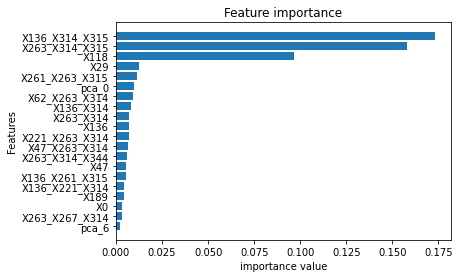

In [64]:
# Ploting feature importance in bar chart
plt.barh(model_imp.index[-21:-1],model_imp.iloc[-21:-1])
plt.xlabel('importance value')
plt.ylabel('Features')
plt.title('Feature importance')
plt.show()

In [65]:
result_compare_df = pd.DataFrame({'Prediction' :y,
                                  'Ground_Truth' : np.array(X['y'])})

In [66]:
result_compare_df['error'] = result_compare_df['Prediction']-result_compare_df['Ground_Truth']

In [67]:
result_compare_df.describe()

,Prediction,Ground_Truth,error
count,4209.000000,4209.000000,4209.000000
mean,100.683537,100.669318,0.014219
std,9.627867,12.679381,8.264664
min,78.112013,72.110000,-169.289209
25%,93.999041,90.820000,-1.711242
50%,94.670173,99.150000,2.281806
75%,111.865392,109.010000,4.630813
max,117.267094,265.320000,12.454876


#### Comparisons of Ground truth and Predictions

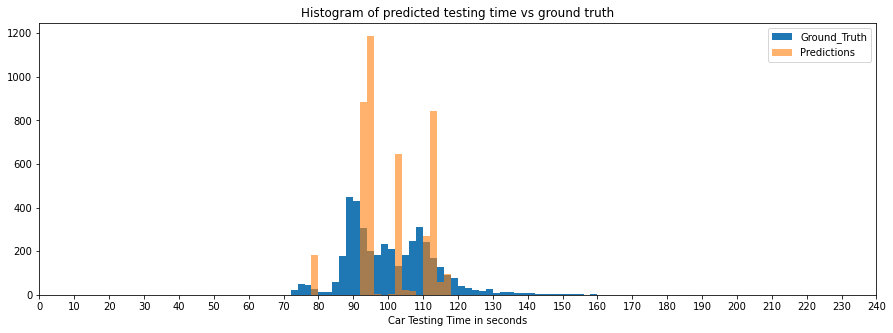

In [68]:
plt.figure(figsize=(15,5))
plt.hist(result_compare_df['Ground_Truth'],bins=range(50,170,2),label='Ground_Truth')
plt.hist(result_compare_df['Prediction'],bins=range(50,170,2),label='Predictions',alpha=0.6)
plt.xticks(range(0,250,10))
plt.xlabel('Car Testing Time in seconds')
plt.title('Histogram of predicted testing time vs ground truth')
plt.legend()
plt.show()

Observation:
Here we see that predictions of the model are concentrated at four regions:

a. Close to 80 seconds

b. in range above 90 to 95

c. just above 100

d. 110 to 120 seconds

### 10 seconds Threshold

In [69]:
# Good Predictions
D1 = result_compare_df[abs(result_compare_df['error'])<=10]

# Bad Predictions
D2 = result_compare_df[abs(result_compare_df['error'])>10]

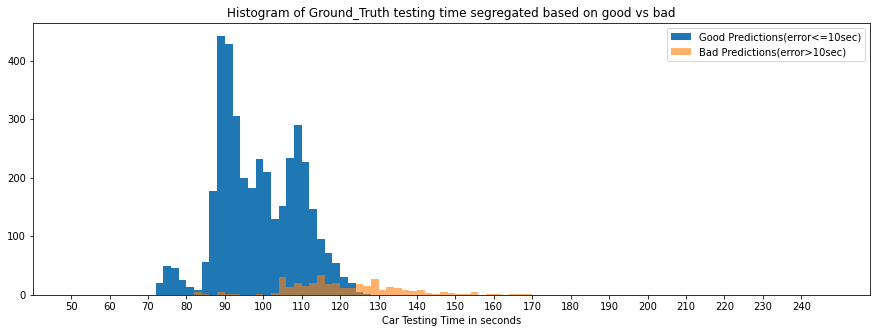

In [70]:
plt.figure(figsize=(15,5))
plt.hist(D1['Ground_Truth'],bins=range(50,250,2),label='Good Predictions(error<=10sec)')
plt.hist(D2['Ground_Truth'],bins=range(50,250,2),label='Bad Predictions(error>10sec)',alpha=0.6)
plt.xticks(range(50,250,10))
plt.xlabel('Car Testing Time in seconds')
plt.title('Histogram of Ground_Truth testing time segregated based on good vs bad')
plt.legend()
plt.show()

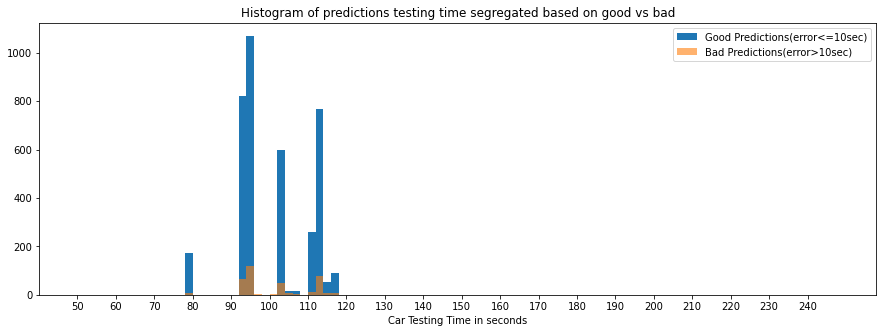

In [71]:
plt.figure(figsize=(15,5))
plt.hist(D1['Prediction'],bins=range(50,250,2),label='Good Predictions(error<=10sec)')
plt.hist(D2['Prediction'],bins=range(50,250,2),label='Bad Predictions(error>10sec)',alpha=0.6)
plt.xticks(range(50,250,10))
plt.xlabel('Car Testing Time in seconds')
plt.title('Histogram of predictions testing time segregated based on good vs bad')
plt.legend()
plt.show()

#### Observations:

Most of the data which have Testing time above 105 seconds are Bad predictions when threshold is 10 seconds

### 5 seconds Threshold

In [72]:
# Good Predictions
D1 = result_compare_df[abs(result_compare_df['error'])<=5]

# Bad Predictions
D2 = result_compare_df[abs(result_compare_df['error'])>5]

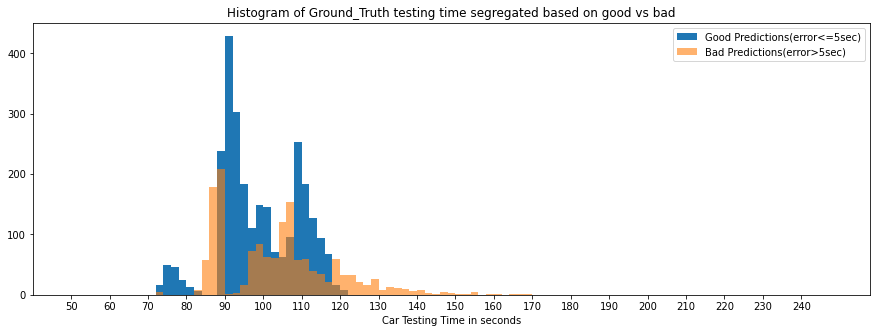

In [73]:
plt.figure(figsize=(15,5))
plt.hist(D1['Ground_Truth'],bins=range(50,250,2),label='Good Predictions(error<=5sec)')
plt.hist(D2['Ground_Truth'],bins=range(50,250,2),label='Bad Predictions(error>5sec)',alpha=0.6)
plt.xticks(range(50,250,10))
plt.xlabel('Car Testing Time in seconds')
plt.title('Histogram of Ground_Truth testing time segregated based on good vs bad')
plt.legend()
plt.show()

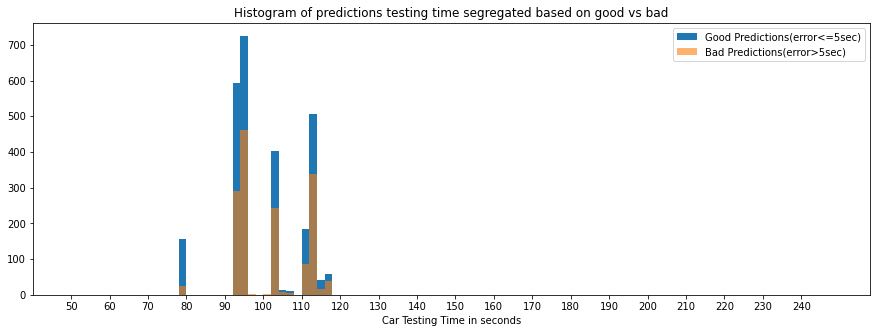

In [74]:
plt.figure(figsize=(15,5))
plt.hist(D1['Prediction'],bins=range(50,250,2),label='Good Predictions(error<=5sec)')
plt.hist(D2['Prediction'],bins=range(50,250,2),label='Bad Predictions(error>5sec)',alpha=0.6)
plt.xlabel('Car Testing Time in seconds')
plt.title('Histogram of predictions testing time segregated based on good vs bad')
plt.xticks(range(50,250,10))
plt.legend()
plt.show()

### Observations:

Here we see that ground truth values which are in range [70,80] , [90,100] and [110,120] are good predictions. Predicted values by model are within error range of 5 secs.

Data with Ground truth values in range [80,90], [95,115], [120 and above] are having Bad predictions

### Distibution of errors

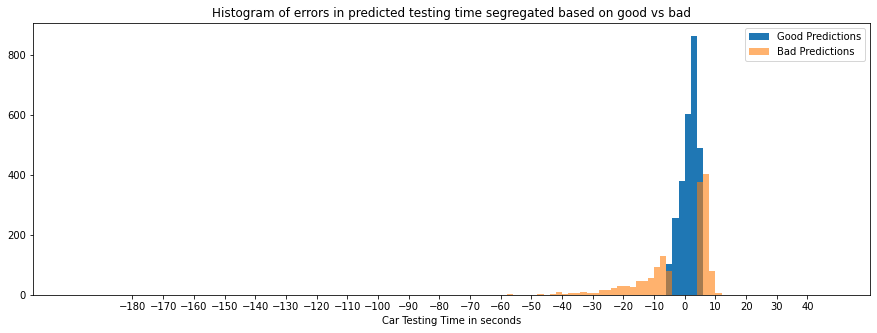

In [75]:
plt.figure(figsize=(15,5))
plt.hist(D1['error'],bins=range(-200,50,2),label='Good Predictions')
plt.hist(D2['error'],bins=range(-200,50,2),label='Bad Predictions',alpha=0.6)
plt.xticks(range(-180,50,10))
plt.xlabel('Car Testing Time in seconds')
plt.title('Histogram of errors in predicted testing time segregated based on good vs bad')
plt.legend()
plt.show()

Here we see that there are certain number of points which are having errors above 10seconds. These points might be outliers which were not identified earlier. These points might drive the model to have low performance on test data

In [76]:
D2[D2.error<-5].describe()

,Prediction,Ground_Truth,error
count,649.000000,649.000000,649.000000
mean,101.052963,115.603837,-14.550874
std,9.308828,15.010740,11.710700
min,78.112013,83.420000,-169.289209
25%,94.109433,104.290000,-18.525141
50%,94.752701,114.180000,-10.637987
75%,112.121965,122.650000,-7.205006
max,117.267094,265.320000,-5.001242


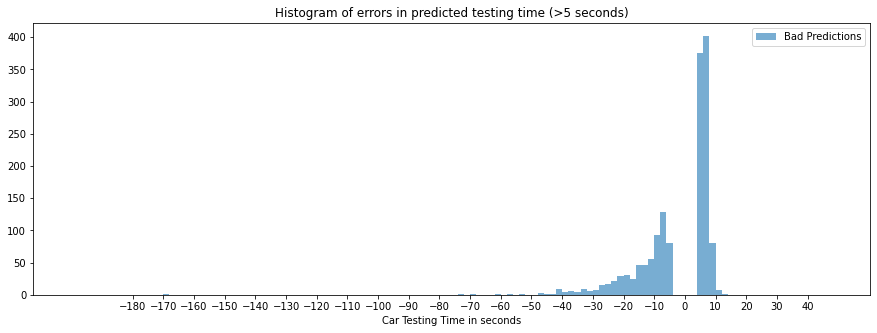

In [21]:
plt.figure(figsize=(15,5))
# plt.hist(D1['error'],bins=range(0,200,2),label='Good Predictions')
plt.hist(D2['error'],bins=range(-200,50,2),label='Bad Predictions',alpha=0.6)
plt.xticks(range(-180,50,10))
plt.xlabel('Car Testing Time in seconds')
plt.title('Histogram of errors in predicted testing time (>5 seconds)')
plt.legend()
plt.show()

In [22]:
D2.describe()

,Prediction,Ground_Truth,error
count,1514.000000,1514.000000,1514.000000
mean,101.513560,104.067853,-2.554294
std,9.000326,15.506492,12.943754
min,78.112013,72.110000,-169.289209
25%,94.128129,88.770000,-9.198033
50%,94.753960,104.035000,5.246478
75%,112.121965,111.580000,6.404377
max,117.267094,265.320000,12.454876


75th percentile error is 9.5 secs. We will check the 

In [23]:
np.percentile(abs(D2['error']),99)#,range(99.1,99.9,0.1))

41.39431283275531

We will identify list of indexes having error above 50 seconds

In [24]:
D2[abs(D2['error'])>50].index

Int64Index([253, 342, 883, 889, 1269, 1459, 3133], dtype='int64')

#### We will remove the above data which are having errors above 50sec and see how the model performs

In [25]:
new_outliers = list(D2[abs(D2['error'])>50].index)

In [26]:
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor

In [27]:
# X = pd.read_csv('test.csv')
X_sample_new = X.drop(new_outliers,axis=0)#.sample(1000)

In [28]:
best_features = ['X189', 'X261', 'X127', 'X313', 'X316', 'X29', 'X136', 'X128', 'X191', 'X350', 'X157', 'X159', 
                         'X234', 'X275', 'X171', 'X156', 'X178', 'X31', 'X315', 'X118', 'X48', 'X148', 'X223', 'X103', 
                         'X185', 'X28', 'X43', 'X334', 'X186', 'X224', 'X187', 'X14', 'X132', 'X51', 'X80', 'X256', 'X46', 
                         'X108', 'X300', 'X286', 'X47', 'X218', 'X180', 'X337', 'X100', 'X64', 'X377', 'X354', 'X168', 'X158', 
                         'X163', 'X273', 'X114', 'X246', 'X304', 'X351', 'X179', 'X45', 'X115', 'X155', 'X19', 'X202', 'X12', 
                         'X126', 'X49', 'X355', 'X349', 'X336', 'X151', 'X98', 'X331', 'X81', 'X142', 'X130', 'X306', 'X22', 
                         'X69', 'X96', 'X111', 'X220', 'X376', 'X68', 'X13', 'X75', 'X85', 'X343', 'X255', 'X203', 'X71', 
                         'X197', 'X61', 'X301', 'X285', 'X27', 'X208']

# Feature modifications
# Target encoding
encoder_list = joblib.load('./joblib_files/target_encoders.joblib')

# Add Interaction feature columns
two_feat_selc = ['X136_X314',
                 'X263_X314',
                 'X314_X315']

three_feat_selc = ['X47_X263_X314',
                   'X62_X263_X314',
                   'X136_X221_X314',
                   'X136_X261_X315',
                   'X136_X314_X315',
                   'X221_X263_X314',
                   'X261_X263_X315',
                   'X263_X267_X314',
                   'X263_X314_X315',
                   'X263_X314_X344']

# Dimensionality reduction methods fit on train data
pca = joblib.load('./joblib_files/pca_transformer.joblib')
tSVD = joblib.load('./joblib_files/tSVD_transformer.joblib')
F_ica = joblib.load('./joblib_files/F_ica_transformer.joblib')

# tSVD components which have correlation with other dimensionality reduction features 
# To be removed after dimention reduction
Dim_redn_corr_feat = ['tSVD_0',
                      'tSVD_1',
                      'tSVD_2',
                      'tSVD_3',
                      'tSVD_7',
                      'tSVD_9',
                      'tSVD_10',
                      'tSVD_11',
                      'tSVD_12',
                      'tSVD_14',
                      'tSVD_15',
                      'tSVD_17',
                      'tSVD_18',
                      'tSVD_19']

# To Get Dimentionality reduction features
X_mod = featurize(X_sample_new,
                  encoder_list,
                  best_features,
                  two_feat_selc,
                  three_feat_selc,
                  pca,
                  tSVD,
                  F_ica,
                  Dim_redn_corr_feat)

In [29]:
ext_reg_f3_f4 = ExtraTreesRegressor(criterion='mse')

In [30]:
ext_params = {'n_estimators':[10,50,100,150,200,250,300],
              'max_depth':[5,10,15,20,25],
              'min_samples_split':[2,3,4,5,6],
              'min_samples_leaf':[1,2,3,4,5,],
              'min_impurity_decrease':[0.15,0.2,0.25]
              }

In [31]:
EXT_Reg_Model_CV = RandomizedSearchCV(ext_reg_f3_f4, 
                                        ext_params,
                                        cv = 30,
                                        scoring='r2',
                                        n_iter = 15,
                                        n_jobs = -1, 
                                        verbose = 10, 
                                        random_state = 25,
                                        return_train_score=True)

In [32]:
# Fitting and evaluating the models
EXT_Reg_Model_CV.fit(X_mod,X_sample_new['y'])

Fitting 30 folds for each of 15 candidates, totalling 450 fits


RandomizedSearchCV(cv=30, estimator=ExtraTreesRegressor(), n_iter=15, n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25],
                                        'min_impurity_decrease': [0.15, 0.2,
                                                                  0.25],
                                        'min_samples_leaf': [1, 2, 3, 4, 5],
                                        'min_samples_split': [2, 3, 4, 5, 6],
                                        'n_estimators': [10, 50, 100, 150, 200,
                                                         250, 300]},
                   random_state=25, return_train_score=True, scoring='r2',
                   verbose=10)

In [33]:
cv_results = pd.DataFrame.from_dict(EXT_Reg_Model_CV.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_min_impurity_decrease,param_max_depth,params,...,split22_train_score,split23_train_score,split24_train_score,split25_train_score,split26_train_score,split27_train_score,split28_train_score,split29_train_score,mean_train_score,std_train_score
0,2.134493,0.145453,0.013831,0.003286,50,2,4,0.15,15,"{'n_estimators': 50, 'min_samples_split': 2, '...",...,0.631161,0.628434,0.630219,0.628750,0.630123,0.626778,0.627262,0.628817,0.630035,0.002654
1,5.180084,0.228194,0.024634,0.005683,150,2,5,0.2,5,"{'n_estimators': 150, 'min_samples_split': 2, ...",...,0.626471,0.622329,0.624080,0.620364,0.624292,0.622068,0.620737,0.623340,0.624486,0.003175
2,3.388208,0.201631,0.017986,0.002768,100,2,3,0.25,25,"{'n_estimators': 100, 'min_samples_split': 2, ...",...,0.623814,0.620308,0.620931,0.620187,0.621849,0.618753,0.617563,0.619944,0.622401,0.003047
3,0.478521,0.029686,0.007447,0.003444,10,5,3,0.15,25,"{'n_estimators': 10, 'min_samples_split': 5, '...",...,0.630582,0.627645,0.628316,0.627955,0.628831,0.630100,0.630579,0.630396,0.630700,0.003353
4,5.228521,0.165645,0.026196,0.003871,150,3,3,0.2,5,"{'n_estimators': 150, 'min_samples_split': 3, ...",...,0.628017,0.623864,0.625224,0.622149,0.625885,0.623460,0.622347,0.624896,0.625929,0.003049
5,11.716011,0.687418,0.042353,0.007177,300,4,4,0.15,15,"{'n_estimators': 300, 'min_samples_split': 4, ...",...,0.631800,0.628627,0.629885,0.628065,0.628891,0.627667,0.627780,0.629328,0.630283,0.002857
6,4.617888,0.197034,0.022041,0.002580,150,3,2,0.25,20,"{'n_estimators': 150, 'min_samples_split': 3, ...",...,0.624846,0.621248,0.621510,0.620820,0.622914,0.619630,0.617975,0.619983,0.623211,0.002986
7,3.535980,0.095335,0.016888,0.002469,100,6,2,0.2,10,"{'n_estimators': 100, 'min_samples_split': 6, ...",...,0.630036,0.625425,0.626740,0.623923,0.627416,0.625434,0.623866,0.626452,0.627556,0.002988
8,9.468619,0.269686,0.036170,0.005130,250,2,4,0.15,15,"{'n_estimators': 250, 'min_samples_split': 2, ...",...,0.631956,0.628192,0.629824,0.627822,0.628916,0.627650,0.627515,0.629896,0.630256,0.002911
9,10.003622,0.280101,0.040758,0.003878,300,6,5,0.2,20,"{'n_estimators': 300, 'min_samples_split': 6, ...",...,0.626486,0.622792,0.623864,0.620939,0.624632,0.622763,0.620836,0.623685,0.624790,0.003194


In [34]:
def score_heatmap(df,param_1,param_2,score):
        '''This function returns heatmap of score in grid of prameters of a model'''
        rows = np.sort(df[param_1].unique())
        columns = np.sort(df[param_2].unique())
        mat = np.zeros((len(rows),len(columns)))
      
        for i in range(len(rows)):
            for j in range(len(columns)):
                for k in range(len(df)):
                    if (df[param_1].iloc[k] == rows[i] and 
                        df[param_2].iloc[k] == columns[j]):
                        mat[i][j] = df[score].iloc[k] 
      
        scores_df = pd.DataFrame(mat,columns = columns, index = rows)
      
        plt.figure(figsize=(6,5))
        sb.heatmap(scores_df,annot=True)
        plt.ylabel(param_1)
        plt.xlabel(param_2)
        plt.title(score)
        plt.show()

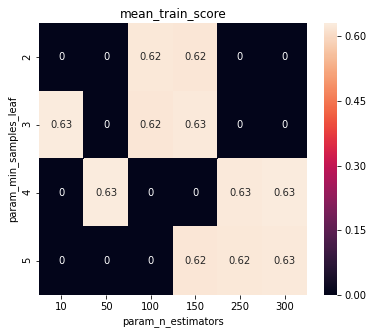

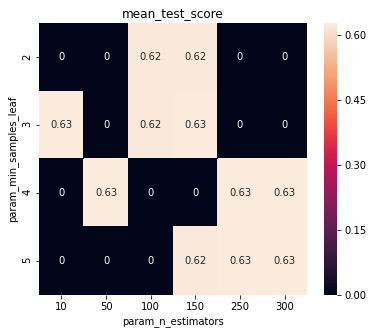

In [35]:
score_heatmap(cv_results,'param_min_samples_leaf','param_n_estimators','mean_train_score')
score_heatmap(cv_results,'param_min_samples_leaf','param_n_estimators','mean_test_score')

In [57]:
# EXT_Reg_Model_CV.best_params_

{'n_estimators': 300,
 'min_samples_split': 5,
 'min_samples_leaf': 5,
 'min_impurity_decrease': 0.15,
 'max_depth': 5}

In [37]:
ext_model = ExtraTreesRegressor(n_estimators = 300,
                                min_samples_split = 5,
                                min_samples_leaf = 5,
                                max_depth = 5,
                                min_impurity_decrease = 0.15) #imp0.21 depth10

In [38]:
ext_model.fit(X_mod,X_sample_new['y'])

ExtraTreesRegressor(max_depth=5, min_impurity_decrease=0.15, min_samples_leaf=5,
                    min_samples_split=5, n_estimators=300)

In [39]:
y = ext_model.predict(X_mod)

#### R2 score

In [40]:
ext_model.score(X_mod,list(X_sample_new['y']))

0.6264233337984042

earlier model training r2 score = 0.5751

new model training r2 score = 0.6266

#### RMSE

In [41]:
mean_squared_error(list(X_sample_new['y']), ext_model.predict(X_mod),squared = False)

7.468390974252373

In [42]:
result_compare_df = pd.DataFrame({'Prediction' :y,
                                  'Ground_Truth' : np.array(X_sample_new['y'])})

In [43]:
result_compare_df['error'] = result_compare_df['Prediction']-result_compare_df['Ground_Truth']

#### Comparisons of Ground truth and Predictions

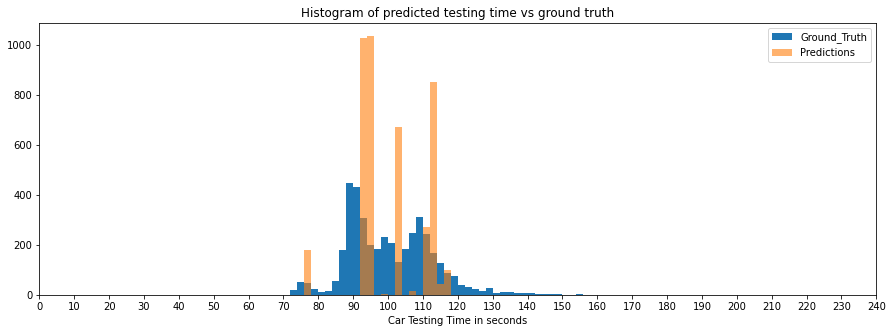

In [44]:
plt.figure(figsize=(15,5))
plt.hist(result_compare_df['Ground_Truth'],bins=range(50,170,2),label='Ground_Truth')
plt.hist(result_compare_df['Prediction'],bins=range(50,170,2),label='Predictions',alpha=0.6)
plt.xticks(range(0,250,10))
plt.xlabel('Car Testing Time in seconds')
plt.title('Histogram of predicted testing time vs ground truth')
plt.legend()
plt.show()

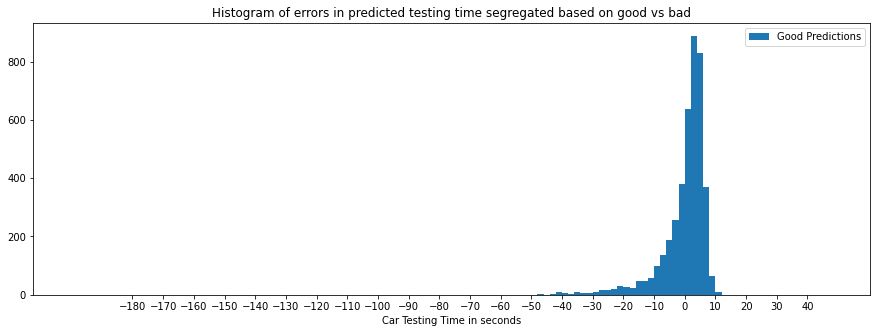

In [45]:
plt.figure(figsize=(15,5))
plt.hist(result_compare_df['error'],bins=range(-200,50,2),label='Good Predictions')
# plt.hist(D2['error'],bins=range(-200,50,2),label='Bad Predictions',alpha=0.6)
plt.xticks(range(-180,50,10))
plt.xlabel('Car Testing Time in seconds')
plt.title('Histogram of errors in predicted testing time segregated based on good vs bad')
plt.legend()
plt.show()

In [46]:
result_compare_df[abs(result_compare_df['error'])>5].describe()

,Prediction,Ground_Truth,error
count,1447.000000,1447.000000,1447.000000
mean,101.300922,104.020601,-2.719679
std,9.000427,14.640045,11.739614
min,77.964862,72.110000,-47.193904
25%,94.021954,88.690000,-9.582150
50%,94.472151,104.180000,5.213081
75%,112.084004,111.740000,6.300663
max,116.809386,160.870000,11.677955


#### Observation:

- After removing datapoints which have testing time error above 50 seconds, we see that number of datapoints which have error above 10 seconds have reduced from 1514 to 1447. 

In [47]:
def features_f2(X):
    ''' This function transforms categorical data to target encoded features and adds best feature'''
#     X0_tgenc = X0_encdr.transform(X['X0'])
#     X1_tgenc = X1_encdr.transform(X['X1'])
#     X2_tgenc = X2_encdr.transform(X['X2'])
#     X3_tgenc = X3_encdr.transform(X['X3'])
#     X5_tgenc = X5_encdr.transform(X['X5'])
#     X6_tgenc = X6_encdr.transform(X['X6'])
#     X8_tgenc = X8_encdr.transform(X['X8'])
    
    X0_tgenc = encoder_list[0].transform(X['X0'])
    X1_tgenc = encoder_list[1].transform(X['X1'])
    X2_tgenc = encoder_list[2].transform(X['X2'])
    X3_tgenc = encoder_list[3].transform(X['X3'])
    X5_tgenc = encoder_list[4].transform(X['X5'])
    X6_tgenc = encoder_list[5].transform(X['X6'])
    X8_tgenc = encoder_list[6].transform(X['X8'])
    
    X_mod = pd.concat([X0_tgenc,
                       X1_tgenc,
                       X2_tgenc,
                       X3_tgenc,
                       X5_tgenc,
                       X6_tgenc,
                       X8_tgenc,
                       X[best_features]],axis=1)
    
    return X_mod

In [48]:
def features_f3(X):
    ''' This function transforms categorical data to target encoded features, 
    adds best feature and two & three way interaction features '''
    
    X_1 = features_f2(X)
    
    # Generating dataframe for selected 2 feature combinations 
    two_feat_dict = dict()
    for feat in two_feat_selc:
        ft_list = feat.split('_')
        two_feat_dict[feat] = X[ft_list[0]] + X[ft_list[1]]
    two_feat_df = pd.DataFrame(two_feat_dict)
    
    # Generating dataframe for selected 3 feature combinations 
    three_feat_dict = dict()
    for feat in three_feat_selc:
        ft_list = feat.split('_')
        three_feat_dict[feat] = X[ft_list[0]] + X[ft_list[1]] + X[ft_list[2]]
    three_feat_df = pd.DataFrame(three_feat_dict)
    
    X_mod = pd.concat([X_1,
                       two_feat_df,
                       three_feat_df],axis=1)
    
    return X_mod

In [49]:
def features_f4(X):
    ''' This function transforms target encoded features and best feature to Dimensional Reduction features '''
    
    X = features_f2(X)
    
    X_pca = pca.transform(X)
    X_pca_df = pd.DataFrame(X_pca, index=list(X.index))
    X_pca_df.columns = [('pca_'+str(i)) for i in range(20)]
    
    X_tSVD = tSVD.transform(X)
    X_tSVD_df = pd.DataFrame(X_tSVD, index=list(X.index))
    X_tSVD_df.columns = [('tSVD_'+str(i)) for i in range(20)]
    
    X_Fica = F_ica.transform(X)
    X_Fica_df = pd.DataFrame(X_Fica, index=list(X.index))
    X_Fica_df.columns = [('ica_'+str(i)) for i in range(20)]
    
    X_mod = pd.concat([X_pca_df,
                       X_tSVD_df,
                       X_Fica_df,],axis=1)
    
    X_mod = X_mod.drop(Dim_redn_corr_feat,axis=1)
    
    return X_mod

In [50]:
def generate_test_data_csv(featurize_name,model,data,link):
    '''This function generates test data predictions in spreadsheet and saves in link'''
    
    if(featurize_name == 'f1'):
        data_mod = features_f1(data)
        
    elif(featurize_name == 'f2'):
        data_mod = features_f2(data)
        
    elif(featurize_name == 'f3'):
        data_mod = features_f3(data)
        
    elif(featurize_name == 'f4'):
        data_mod = features_f4(data)
        
    elif(featurize_name == 'f5'):
        data_mod = features_f5(data)
    
    elif(featurize_name == 'f3_f4'):
        data_mod3 = features_f3(data)
        data_mod4 = features_f4(data)
        data_mod = pd.concat([data_mod3,data_mod4],axis=1)
        
    elif(featurize_name == 'f1_f5'):
        data_mod1 = features_f1(data)
        data_mod5 = features_f5(data)
        data_mod = pd.concat([data_mod1,data_mod5],axis=1)
        
    pred = model.predict(data_mod)
    
    predictions = pd.DataFrame({'ID' : data.ID.values,
                                 'y' : pred})
    
    predictions.to_csv(link,index = False)

In [51]:
car_data_test = pd.read_csv('test.csv')

In [52]:
generate_test_data_csv('f3_f4', ext_model, car_data_test, 'test_data_predictions_olr_fd\ext_model_new_olr.csv')

Kaggle Score

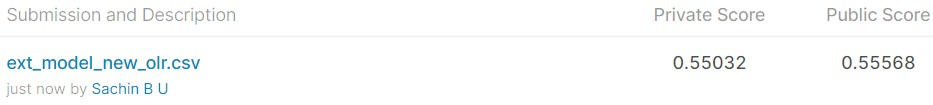

In [53]:
display.Image("test_data_predictions_olr_fd\ext_model_new_olr.jpg")

#### There is no improvement in kaggle private score

### Bias and Variance

In [54]:
X = pd.read_csv('train.csv')

In [55]:
best_features = ['X189', 'X261', 'X127', 'X313', 'X316', 'X29', 'X136', 'X128', 'X191', 'X350', 'X157', 'X159', 
                         'X234', 'X275', 'X171', 'X156', 'X178', 'X31', 'X315', 'X118', 'X48', 'X148', 'X223', 'X103', 
                         'X185', 'X28', 'X43', 'X334', 'X186', 'X224', 'X187', 'X14', 'X132', 'X51', 'X80', 'X256', 'X46', 
                         'X108', 'X300', 'X286', 'X47', 'X218', 'X180', 'X337', 'X100', 'X64', 'X377', 'X354', 'X168', 'X158', 
                         'X163', 'X273', 'X114', 'X246', 'X304', 'X351', 'X179', 'X45', 'X115', 'X155', 'X19', 'X202', 'X12', 
                         'X126', 'X49', 'X355', 'X349', 'X336', 'X151', 'X98', 'X331', 'X81', 'X142', 'X130', 'X306', 'X22', 
                         'X69', 'X96', 'X111', 'X220', 'X376', 'X68', 'X13', 'X75', 'X85', 'X343', 'X255', 'X203', 'X71', 
                         'X197', 'X61', 'X301', 'X285', 'X27', 'X208']

# Feature modifications
# Target encoding
encoder_list = joblib.load('./joblib_files/target_encoders.joblib')

# Add Interaction feature columns
two_feat_selc = ['X136_X314',
                 'X263_X314',
                 'X314_X315']

three_feat_selc = ['X47_X263_X314',
                   'X62_X263_X314',
                   'X136_X221_X314',
                   'X136_X261_X315',
                   'X136_X314_X315',
                   'X221_X263_X314',
                   'X261_X263_X315',
                   'X263_X267_X314',
                   'X263_X314_X315',
                   'X263_X314_X344']

# Dimensionality reduction methods fit on train data
pca = joblib.load('./joblib_files/pca_transformer.joblib')
tSVD = joblib.load('./joblib_files/tSVD_transformer.joblib')
F_ica = joblib.load('./joblib_files/F_ica_transformer.joblib')

# tSVD components which have correlation with other dimensionality reduction features 
# To be removed after dimention reduction
Dim_redn_corr_feat = ['tSVD_0',
                      'tSVD_1',
                      'tSVD_2',
                      'tSVD_3',
                      'tSVD_7',
                      'tSVD_9',
                      'tSVD_10',
                      'tSVD_11',
                      'tSVD_12',
                      'tSVD_14',
                      'tSVD_15',
                      'tSVD_17',
                      'tSVD_18',
                      'tSVD_19']

# To Get Dimentionality reduction features
X_mod = featurize(X,
                  encoder_list,
                  best_features,
                  two_feat_selc,
                  three_feat_selc,
                  pca,
                  tSVD,
                  F_ica,
                  Dim_redn_corr_feat)

In [56]:
ext_model = ExtraTreesRegressor(n_estimators = 300,
                                min_samples_split = 5,
                                min_samples_leaf = 5,
                                max_depth = 5,
                                min_impurity_decrease = 0.15) #imp0.21 depth10

In [58]:
train_X, test_X, train_y, test_y = train_test_split(X_mod, 
                                                    X['y'], 
                                                    test_size=0.25, 
                                                    random_state=42)

In [61]:
train_score = []
test_score = []
batch_size = int(len(train_X)/100)
for i in tqdm(range(100)):
    start = 0 #i * batch_size
    end = start + batch_size * (i+1)
    
    ext_model.fit(train_X.iloc[start:end],train_y.iloc[start:end])
    y_pred1 = ext_model.predict(train_X)
    train_score.append(r2_score(train_y,y_pred1))
    
    y_pred2 = ext_model.predict(test_X)
    test_score.append(r2_score(test_y,y_pred2))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:25<00:00,  2.06s/it]


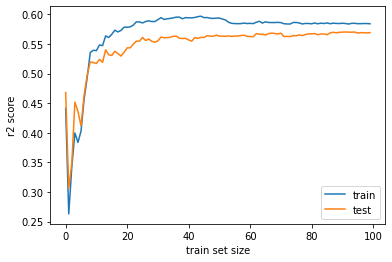

In [78]:
plt.plot(train_score,label='train')
plt.plot(test_score,label='test')
plt.legend()
plt.xlabel('train set size')
plt.ylabel('r2 score')
plt.show()

In [59]:
train_score_rmse = []
test_score_rmse = []
batch_size = int(len(train_X)/100)
for i in tqdm(range(100)):
    start = 0 #i * batch_size
    end = start + batch_size * (i+1)
    
    ext_model.fit(train_X.iloc[start:end],train_y.iloc[start:end])
    y_pred1 = ext_model.predict(train_X)
    train_score_rmse.append(mean_squared_error(train_y,y_pred1,squared=False))
    
    y_pred2 = ext_model.predict(test_X)
    test_score_rmse.append(mean_squared_error(test_y,y_pred2,squared=False))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:22<00:00,  2.03s/it]


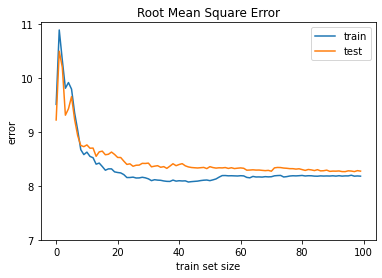

In [60]:
plt.plot(train_score_rmse,label='train')
plt.plot(test_score_rmse,label='test')
plt.yticks([7,8,9,10,11])
plt.legend()
plt.title('Root Mean Square Error')
plt.xlabel('train set size')
plt.ylabel('error')
plt.show()

#### Observations

When we compare the above plot with above mentioned 4 types of behaviour, our model is 4th type i.e. it has high bias and high variance.

Note: Our model is trained on batches, hence the initial train error are not low.

- Errors of train data doesn't decrease with larger dataset size thus we can say there is bias in model prediction.
- Errors of test data doesn't decrease with larger dataset size that indicates there is variance in model.

The model doesn't fit the train data very well. This indicates there is requirement to increase or modify features. To perform better on test data, the model needs to be trained on more data which is not possible for the considered data.

To decrease bias in tree based models we need to check with deeper trees. We can also try different models such as linear regression with features which have polynomial relationship and neural network models which can handle non linear relation among the features.